In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

# Read Data
df_model = pd.read_csv('df_model.csv')

df_model.drop(['DATE', 'TIMESTAMP', 'TIME_SLOT_HR', 'TIME_SLOT_MIN'], axis=1, inplace=True)

train_indx = range(0, 55000)
val_indx = range(55000, 80000)
test_indx = range(80000, df_model.shape[0])

# Normalize numeric columns
num_cols = df_model.columns[df_model.dtypes =='float64']

mean = df_model.loc[train_indx, num_cols].mean(axis = 0)
sd = df_model.loc[train_indx, num_cols].std(axis = 0)
df_model[num_cols] = df_model[num_cols] - mean
df_model[num_cols] = df_model[num_cols]/sd


# Function to shift y values
sign = lambda x: (1, -1)[x < 0]
def fn_data_shift(data, shift=-72, ycol='FLG_FAIL', out_col='FLG_FAIL_SHIFTED'):
    vec = data[ycol].copy()
    
    for i in range(abs(shift)):
        temp = vec.shift(sign(shift))
        temp = temp.fillna(0)
        vec = vec + temp
    
    data[out_col] = vec
    data.loc[data[out_col]>0, out_col] = 1
    
    return data

df_model_shifted = fn_data_shift(data=df_model, shift=-144) # Aim to Predict 1 day before failure

# Drop data for original failure
rwdrop_indx = df_model_shifted[df_model_shifted['FLG_FAIL']==1].index
df_model_shifted = df_model_shifted.drop(rwdrop_indx)
df_model_shifted.drop('FLG_FAIL', axis=1, inplace=True) # Drop original column

df_model_shifted.shape

(108379, 110)

In [34]:
# divide data into train/test/valid

train_indx = range(0, 60000)
val_indx = range(60000, 90000)
test_indx = range(75000, df_model_shifted.shape[0])

df_train = df_model_shifted.iloc[train_indx]
df_val = df_model_shifted.iloc[val_indx]
df_test = df_model_shifted.iloc[test_indx]

# Separate 0/1 instances for auto encoder approach
df_train_x0 = df_train.loc[df_train['FLG_FAIL_SHIFTED']==0, df_train.columns !='FLG_FAIL_SHIFTED']
df_train_y0 = df_train.loc[df_train['FLG_FAIL_SHIFTED']==0, 'FLG_FAIL_SHIFTED']
df_train_x1 = df_train.loc[df_train['FLG_FAIL_SHIFTED']==1, df_train.columns !='FLG_FAIL_SHIFTED']
df_train_y1 = df_train.loc[df_train['FLG_FAIL_SHIFTED']==1, 'FLG_FAIL_SHIFTED']

df_val_x0 = df_val.loc[df_val['FLG_FAIL_SHIFTED']==0, df_val.columns !='FLG_FAIL_SHIFTED']
df_val_y0 = df_val.loc[df_val['FLG_FAIL_SHIFTED']==0, 'FLG_FAIL_SHIFTED']
df_val_x1 = df_val.loc[df_val['FLG_FAIL_SHIFTED']==1, df_val.columns !='FLG_FAIL_SHIFTED']
df_val_y1 = df_val.loc[df_val['FLG_FAIL_SHIFTED']==1, 'FLG_FAIL_SHIFTED']

df_test_x0 = df_test.loc[df_test['FLG_FAIL_SHIFTED']==0, df_test.columns !='FLG_FAIL_SHIFTED']
df_test_y0 = df_test.loc[df_test['FLG_FAIL_SHIFTED']==0, 'FLG_FAIL_SHIFTED']
df_test_x1 = df_test.loc[df_test['FLG_FAIL_SHIFTED']==1, df_test.columns !='FLG_FAIL_SHIFTED']
df_test_y1 = df_test.loc[df_test['FLG_FAIL_SHIFTED']==1, 'FLG_FAIL_SHIFTED']

print(df_train_x0.shape, df_train_y0.shape, df_train_x1.shape, df_train_y1.shape)
print(df_val_x0.shape, df_val_y0.shape, df_val_x1.shape, df_val_y1.shape)
print(df_test_x0.shape, df_test_y0.shape, df_test_x1.shape, df_test_y1.shape)

(58128, 109) (58128,) (1872, 109) (1872,)
(29136, 109) (29136,) (864, 109) (864,)
(32947, 109) (32947,) (432, 109) (432,)


In [35]:
#df_model_X = df_model_shifted.loc[:, df_model_shifted.columns!='FLG_FAIL_SHIFTED']
#df_model_y = df_model_shifted['FLG_FAIL_SHIFTED'].values

#df_model_X.shape, df_model_y.shape

# Function to convert data to 3d tensor
def fn_3dop(data , y_in , lookback, step):
    
    samples = np.zeros((len(data)-lookback+1, lookback//step, data.shape[-1]))
    target = np.zeros((len(data)-lookback+1))
    
    print(samples.shape, target.shape)
    
    start_indx = lookback - 1
    end_indx = len(data)
    nrows = end_indx - start_indx
    
    for i in range(nrows):
        indx = range(i,i+lookback, step)
        samples[i] = data[indx]
        target[i] = y_in[indx][-1]
        
    return samples, target

In [36]:
df_train_x0 = np.array(df_train_x0)
df_train_y0 = np.array(df_train_y0)

df_val_x0 = np.array(df_val_x0)
df_val_y0 = np.array(df_val_y0)

df_test_x0 = np.array(df_test_x0)
df_test_y0 = np.array(df_test_y0)

In [37]:
df_train_x0_3d, df_train_y0_3d = fn_3dop(df_train_x0, y_in=df_train_y0, lookback=72, step=3)
df_val_x0_3d, df_val_y0_3d = fn_3dop(df_val_x0, y_in=df_val_y0, lookback=72, step=3)

(58057, 24, 109) (58057,)
(29065, 24, 109) (29065,)


In [44]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed

lstm_autoencoder = Sequential()

In [45]:
n_timestamps = df_train_x0_3d.shape[1]
n_features = df_train_x0_3d.shape[2]

lstm_autoencoder.add(LSTM(32, activation='relu', input_shape=(n_timestamps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(n_timestamps))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 24, 32)            18176     
_________________________________________________________________
lstm_10 (LSTM)               (None, 16)                3136      
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 24, 16)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 24, 16)            2112      
_________________________________________________________________
lstm_12 (LSTM)               (None, 24, 32)            6272      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 24, 109)           3597      
Total params: 33,293
Trainable params: 33,293
Non-trainable params: 0
_________________________________________________________________


In [46]:
lstm_autoencoder.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

lstm_history = lstm_autoencoder.fit(df_train_x0_3d, df_train_x0_3d,
                                   epochs=15,
                                   batch_size=144,
                                   validation_data=(df_val_x0_3d, df_val_x0_3d))

Train on 58057 samples, validate on 29065 samples
Epoch 1/15
58057/58057 [==============================] - 77s 1ms/step - loss: 0.1419 - acc: 0.1599 - val_loss: 0.9896 - val_acc: 0.2432
Epoch 2/15
58057/58057 [==============================] - 74s 1ms/step - loss: 0.0722 - acc: 0.4031 - val_loss: 0.9662 - val_acc: 0.3447
Epoch 3/15
58057/58057 [==============================] - 74s 1ms/step - loss: 0.0652 - acc: 0.4350 - val_loss: 0.9577 - val_acc: 0.3844
Epoch 4/15
58057/58057 [==============================] - 75s 1ms/step - loss: 0.0647 - acc: 0.4263 - val_loss: 1.0049 - val_acc: 0.4305
Epoch 5/15
58057/58057 [==============================] - 74s 1ms/step - loss: 0.0636 - acc: 0.4171 - val_loss: 1.0906 - val_acc: 0.3642
Epoch 6/15
58057/58057 [==============================] - 74s 1ms/step - loss: 0.0616 - acc: 0.4302 - val_loss: 0.9804 - val_acc: 0.4309
Epoch 7/15
58057/58057 [==============================] - 74s 1ms/step - loss: 0.0580 - acc: 0.4504 - val_loss: 0.9679 - val_acc

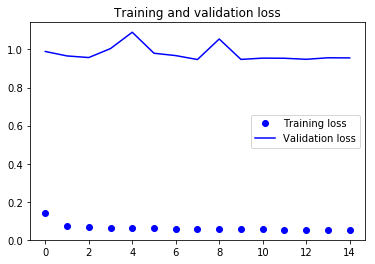

In [47]:
import matplotlib.pyplot as plt

loss = lstm_history.history['loss']
val_loss = lstm_history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [51]:
# Create 3d tensor
df_val_x_3d, df_val_y = fn_3dop(data=np.array(df_val.loc[:, df_val.columns!='FLG_FAIL_SHIFTED']), 
                                  lookback=72, step=3, 
                                  y_in=np.array(df_val['FLG_FAIL_SHIFTED']))

val_predict = lstm_autoencoder.predict(df_val_x_3d)

# convert to 2d for comparision
val_predict_2d = np.empty((val_predict.shape[0], val_predict.shape[2]))
for i in range(val_predict.shape[0]):
    val_predict_2d[i] = val_predict[i, (val_predict.shape[1]-1), :]
    
val_in_2d = np.empty((df_val_x_3d.shape[0], df_val_x_3d.shape[2]))
for i in range(df_val_x_3d.shape[0]):
    val_in_2d[i] = df_val_x_3d[i, (df_val_x_3d.shape[1]-1), :]

(29929, 24, 109) (29929,)


In [63]:
mse = np.mean(np.power(val_in_2d - val_predict_2d, 2), axis=1)

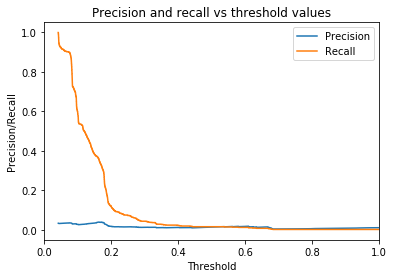

In [71]:
df_error = pd.DataFrame({'RECONSTRUCTION_ERROR':mse, 'TRUE_CLASS':df_val_y.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(df_error['TRUE_CLASS'], df_error['RECONSTRUCTION_ERROR'])
plt.plot(threshold_rt, precision_rt[1:], label='Precision')
plt.plot(threshold_rt, recall_rt[1:], label='Recall')
plt.xlim(0, 1)
plt.title('Precision and recall vs threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [ ]:
test_pred = autoencoder.predict(df_test_x0.loc[:, df_test_x0.columns!='FLG_FAIL_SHIFTED'])
mse = np.mean(np.power(df_test_x0.loc[:, df_test_x0.columns!='FLG_FAIL_SHIFTED']-test_pred, 1), axis=1)

df_error_test = pd.DataFrame({'RECONSTRUCTION_ERROR':mse, 'TRUE_CLASS':df_test['FLG_FAIL_SHIFTED']})
cutoff = 0.05

pred = [1 if error > cutoff else 0 for error in df_error_test['RECONSTRUCTION_ERROR'].values]
confusion_matrix(df_error_test['TRUE_CLASS'], pred)